# Feature Creation

---

This concerns the steps 2 & 3 from the [General Model Approach](./README.md#General-Model-Approach):

**2. Render each word in the review text to a canonical form.**

**3. Use a predefined set of words, a _target word set_, to create a feature vector of binary features, each indicating the presence or absence of one of the words in the target word set.**


**Step 2** will be the same for all models we define.

**Step 3** is similar to what we did for the labels in our [baseline model](./reviwed_grapes.method_baseline.pyspark.v1.ipynb) but this time we do it for the canonical words in the reviews.

We carry out different approaches for step 3, leading to different target word sets: 

- [Most Common Word](#Most-Common-Words)

- [Word2Vector Based](#Word2Vec-Based)
  - [Similar Words](#Similar-Words)
  - [Dissimilar Words](#Dissimilar-Words)
  - [Extremes Word Set](#Extremes-Word-Set)
  - [Low Entropy Word Set](#Low-Entropy-Word-Set)

---

In [1]:
import json
import numpy as np
from pyspark.sql import SparkSession, SQLContext
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer
from pyspark.sql.functions import udf, col
from pyspark.sql.types import ArrayType, StringType
from matplotlib import pyplot as plt
from IPython.display import Markdown, display

In [2]:
%matplotlib inline
def warn(string):
    display(Markdown('<span style="color:red">'+string+'</span>'))
def info(string):
    display(Markdown('<span style="color:blue">'+string+'</span>'))

In [3]:
spark = SparkSession.builder \
    .master("local[*]") \
    .config("spark.driver.maxResultSize", "1g") \
    .config("spark.driver.memory", "20g") \
    .appName("jojoSparkSession") \
    .getOrCreate()
    # .config("spark.driver.memory", "20g") \
    # .config("spark.default.parallelism", "16") \
    # .config("spark.executor.cores", "16") \
sc = spark.sparkContext
sqlContext = SQLContext(sc) 

In [4]:
# load the dataset
reviews_sdf = spark.read.parquet('data/reviews_cleaned')
reviews_sdf.show()

+-----+--------------------+------------------+
|index|         description|           variety|
+-----+--------------------+------------------+
|    0|aromas include tr...|       white blend|
|    1|this is ripe and ...|    portuguese red|
|    2|tart and snappy, ...|        pinot gris|
|    3|pineapple rind, l...|          riesling|
|    4|much like the reg...|        pinot noir|
|    7|this dry and rest...|    gewürztraminer|
|    8|savory dried thym...|    gewürztraminer|
|    9|this has great de...|        pinot gris|
|   10|soft, supple plum...|cabernet sauvignon|
|   11|this is a dry win...|    gewürztraminer|
|   12|slightly reduced,...|cabernet sauvignon|
|   14|building on 150 y...|        chardonnay|
|   15|zesty orange peel...|          riesling|
|   16|baked plum, molas...|            malbec|
|   17|raw black-cherry ...|            malbec|
|   18|desiccated blackb...| tempranillo blend|
|   19|red fruit aromas ...|          meritage|
|   20|ripe aromas of da...|         red

## Canonical Words (step 2)

As a first feature engineering step we will take the text in the `description` column and convert it to a list of canonical words.

Naively, we could simply split the text into single words.
However, since words change with declination we need to convert them to a canonical form.
The python package [nltk](https://www.nltk.org/) can help us here and we use what is called [Lemmatisation](https://en.wikipedia.org/wiki/Lemmatisation).

Also we get rid of common [stopwords](https://en.wikipedia.org/wiki/Stop_words), i.e. words that are common but without relevant information content and we define a custom _blacklist_ of words we are sure will not help us for the prediction.

To start, we get common English stopwords from the nltk package:

In [5]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
# get common english stopwords:
en_stopwords = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /home/jonas/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Now we define our own blacklist of words, i.e. words we do not want to include in the tarcking set.

In [6]:
# our custom blacklist:
blacklist = set(['wine', 'drink', 'variety', 'show', 'offer', 'make', 'give', 'well',
                 'open', 'come', 'years', 'bottle', 'mouth', 'like', 'also', 'along',
                 'alongside', 'vineyard', 'ready', 'great', 'one', 'slightly', 'deliver',
                 'yet', 'add', 'need', 'big', 'bring', 'easy', 'oral', 'best', 'end', 'alcohol'])
# now we combine it with the stopwords
stop_words = list(en_stopwords.union(blacklist))

Up next we need to write a routine that processes the text in the `description` column by lemmatizing the words and creating a set of words that occur.

Also for this we define a custom transformer, we'll call _NLTKLemmatizer_, by sub-classing pyspark's [Transformer](https://spark.apache.org/docs/3.1.1/api/python/reference/api/pyspark.ml.Transformer.html).

The class is defined in [./reviewed_grapes/transformers.py](./reviewed_grapes/transformers.py) and can simply be used like any other pyspark Transformer:

In [7]:
# import the custom Transformer class
from reviewed_grapes.transformers import NLTKLemmatizer
# instatiate our transformer:
nltkl = NLTKLemmatizer(inputCol='description', outputCol='words', stopWords=stop_words)

[nltk_data] Downloading package punkt to /home/jonas/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jonas/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [8]:
cannonical = nltkl.transform(reviews_sdf).select('description', 'words')
for row in cannonical.take(5):
    description, words = row
    print("Text:\n\t%s\nLemmatized Words:\n\t%s\n\n" % (description, words))

Text:
	aromas include tropical fruit, broom, brimstone and dried herb. the palate isn't overly expressive, offering unripened apple, citrus and dried sage alongside brisk acidity.
Lemmatized Words:
	['herb', 'overly', 'offer', 'tropical', 'expressive', 'include', 'broom', 'unripened', 'aromas', 'palate', 'brimstone', 'sage', 'dry', 'brisk', 'fruit', 'acidity', 'apple', 'citrus']


Text:
	this is ripe and fruity, a wine that is smooth while still structured. firm tannins are filled out with juicy red berry fruits and freshened with acidity. it's  already drinkable, although it will certainly be better from 2016.
Lemmatized Words:
	['still', 'better', 'certainly', 'drinkable', 'fruit', 'fill', 'fruity', 'structure', 'berry', 'freshen', 'acidity', 'firm', 'ripe', 'juicy', 'tannins', 'although', 'smooth', 'already', 'red']


Text:
	tart and snappy, the flavors of lime flesh and rind dominate. some green pineapple pokes through, with crisp acidity underscoring the flavors. the wine was all 

**So we can simply include an instance of our `NLTKLemmatizer` when we define a pipeline in our model definition.**

---

## Target Word Set

This concerns stage 3 in our approach.
Basically, we need to create a set of words to track.

In what follows we explore different ways to do so.

### Most Common Words

In this case our target word set simply consists of the _x_-most commonly used words in the review texts.
There is no ready made function in pyspark that would allow to compute such list, so we write one and wrap it into a custom [Estimator](https://spark.apache.org/docs/3.1.1/api/python/reference/api/pyspark.ml.Estimator.html) just like we did for the `MarginalMaximizer` in our [Baseline Model](reviewed_grapes.baseline.model_def.pyspark.v1.ipynb).

Our custom `WordSetTracker` is defined [utils/Estimators.py](./utils/Estimators.py)

In [9]:
# import the custom estimator
from utils.Estimators import WordSetTracker

In [10]:
# how long should the list of most common words be?
nbrWords = 1000
# initiate the estimator
wst = WordSetTracker(inputCol='words', outputCol='features', limitTo=nbrWords)

Let's process our dataset and see what we get:

In [11]:
%%time
preview_model = Pipeline(stages=[nltkl, wst]).fit(reviews_sdf)

CPU times: user 81.7 ms, sys: 5.47 ms, total: 87.2 ms
Wall time: 1min 11s


We can now access the attributes `wordSet` and `wordCount` from our custom estimator and do some exploration:

In [12]:
wst_model = preview_model.stages[1]
word_set = wst_model.getWordSet()
word_count = wst_model.getWordCount()

In [13]:
# Save the list for later use
with open('data/targetWordSets/common_words.json', 'w') as fo:
    json.dump(word_set, fo)


#### 100 most used words and how often they occur in reviews

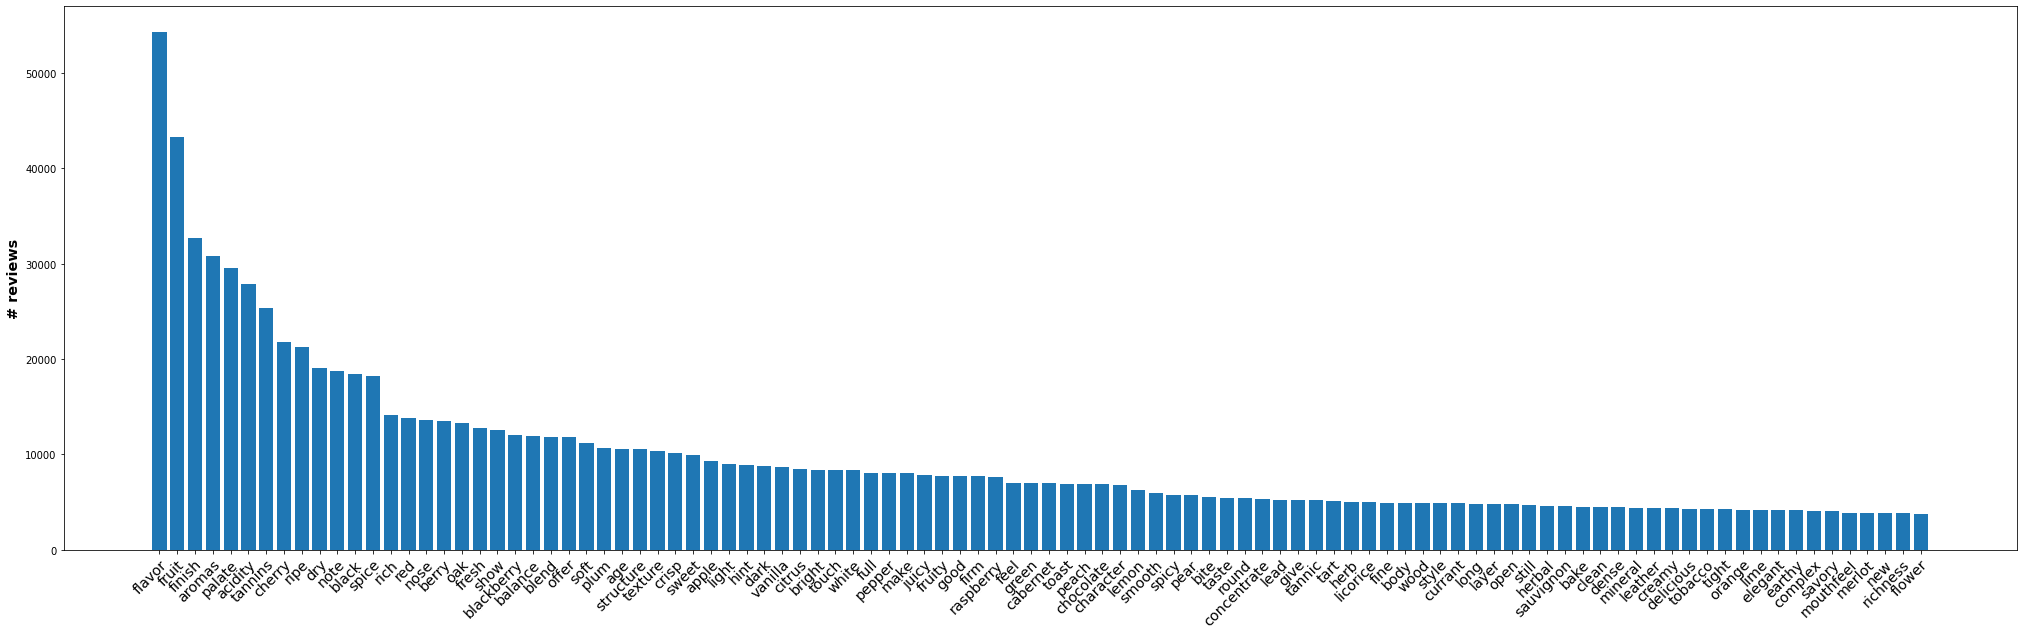

In [15]:
# let's have a look at the top most common words
word_set = word_set[:100]
word_count = word_count[:100]
display(Markdown(f'\n#### {len(word_set)} most used words and how often they occur in reviews'))
fig, ax = plt.subplots(figsize=(35, 10))
ax.bar(word_set, word_count)
plt.xticks(rotation=45, fontsize='x-large', ha='right', va='top', rotation_mode='anchor')
ax.set_ylabel('# reviews', fontweight='bold', fontsize='x-large')
plt.show()

So far so good!

**With our custom estimator, `WordSetTracker`, we can compute the list of most common words.**

So also this step can now simply be included in a Pipeline.

---

### Word2Vec Based

Now to the fun part!

**Here we implement a deep learning model**, a variation of an auto-encoder to be clear, that will allow us to embed all canonical words in the review texts, as well as, all the wine varieties into a vector space.

Based on this vector space we then assess the similarity between words and wine varieties and compile target words set based on similarity considerations.

---
**Note:** Spark implements its own [Word2Vec](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.feature.Word2Vec.html) estimator, which makes things rather easy and allows  a seamless pipeline-syntax.
We use this estimator here in our feature creation.
However, **an implementation in [keras](https://keras.io/) and one in [elephas](https://github.com/maxpumperla/elephas) (allowing to run keras on spark) are also implemented.**

The keras + elephas implementation can be found in [reviewed_grapes.feature_eng_SI.pyspark_keras_elephas.v1.ipynb](reviewed_grapes.feature_eng_SI.pyspark_keras_elephas.v1.ipynb).
___



To start, we first get the dataset ready.
Here we will already run the `WordSetTracker` once with a high number of most common words, i.e. 5000.
This is to limit the number of word-pairs we create for our word-2-vector encoding.

In [5]:
from reviewed_grapes.transformers import NLTKLemmatizer
from utils.Estimators import WordSetTracker
# Index the labels:
si = StringIndexer(inputCol='variety', outputCol='label', handleInvalid='keep')
# Create canonical word list
from nltk.corpus import stopwords
# get common english stopwords:
en_stopwords = set(stopwords.words('english'))
blacklist = set(['wine', 'drink', 'variety', 'show', 'offer', 'make', 'give', 'well',
                 'open', 'come', 'years', 'bottle', 'mouth', 'like', 'also', 'along',
                 'alongside', 'vineyard', 'ready', 'great', 'one', 'slightly', 'deliver',
                 'yet', 'add', 'need', 'big', 'bring', 'easy', 'oral', 'best', 'end', 'alcohol'])
stop_words = list(en_stopwords.union(blacklist))
nltkl = NLTKLemmatizer(inputCol='description', outputCol='words', stopWords=stop_words)
# Set up a pipeline
prep_ppl = Pipeline(stages=[si, nltkl])

[nltk_data] Downloading package punkt to /home/jonas/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jonas/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [6]:
%%time
prep_nltk_fitted = prep_ppl.fit(reviews_sdf)
nltk_ready = prep_nltk_fitted.transform(reviews_sdf)

CPU times: user 16.3 ms, sys: 4.07 ms, total: 20.4 ms
Wall time: 1.76 s


**Considerations:**

Since our dataset is not balanced and we have many more reviews for certain wine varieties,
we would also pick-up this bias towards certain wine varieties in our word-2-vector encoding.

To avoid this we create a balanced dataset and use this dataset for the word encoding.
Creating a balanced dataset can be achieved by stratified sampling, however, if we do so,
we will ignore some samples for the more frequent wine varieties.
To avoid this, we adapt another approach and 'upscale' our dataset.
In particular we resample the entries for each wine variety until each wine variety has the same number of samples.
Note that all wine varieties will simply keep all its samples and that, with the exception of the most common one, 
all varieties will have some of their samples duplicated.

In [7]:
# StringIndexer is rather helpful as it associates the index 0.0 to the most common lable.
# We can thus easily get to count of the most common label with: 
target_count = nltk_ready.filter(nltk_ready.label==0.0).count()
print(f'{target_count=}')

target_count=12277


Now we will 'upscale' the number of samples for any other label, in order to get the same count for each label.
We do this by sampling with replacement:

In [8]:
%%time
# get all different labels present (i.e. all wine varieties)
all_labels = sorted(np.array(nltk_ready.select('label').distinct().collect()).reshape(-1))
# number of different labels (i.e. varieties)
nbr_labels = len(all_labels)
total_count = nltk_ready.count()
print(f'{total_count=}')
# we construct a new dataset that will hold the balanced review data
nltk_upscaled = nltk_ready.alias('w2v_upscaled')
# now we process each label
# (with the exception of the first as there is nothing to do)
for label in all_labels[1:]:
    label_entries = nltk_ready.filter(nltk_ready.label==label)
    nbr_entries = label_entries.count()
    needed = target_count - nbr_entries
    upscale_factor = needed / nbr_entries
    # now we sample
    new_entries = nltk_ready.sample(True, upscale_factor).take(needed)
    nltk_upscaled = nltk_upscaled.union(sc.parallelize(new_entries).toDF())
    added = len(new_entries)
    print(f'upsacling {label=}\t duplicated {added} entries')

total_count=108234
upsacling label=1.0	 duplicated 1410 entries
upsacling label=2.0	 duplicated 3439 entries
upsacling label=3.0	 duplicated 4036 entries
upsacling label=4.0	 duplicated 5808 entries
upsacling label=5.0	 duplicated 7504 entries
upsacling label=6.0	 duplicated 7702 entries
upsacling label=7.0	 duplicated 8451 entries
upsacling label=8.0	 duplicated 9057 entries
upsacling label=9.0	 duplicated 9381 entries
upsacling label=10.0	 duplicated 9675 entries
upsacling label=11.0	 duplicated 9747 entries
upsacling label=12.0	 duplicated 9817 entries
upsacling label=13.0	 duplicated 9831 entries
upsacling label=14.0	 duplicated 9995 entries
upsacling label=15.0	 duplicated 10098 entries
upsacling label=16.0	 duplicated 10306 entries
upsacling label=17.0	 duplicated 10606 entries
upsacling label=18.0	 duplicated 10934 entries
upsacling label=19.0	 duplicated 10953 entries
upsacling label=20.0	 duplicated 10969 entries
upsacling label=21.0	 duplicated 11034 entries
upsacling label=2

Now we can get the word count from the balanced dataset

In [9]:
# Compute list of most common words
# (we use indexWords=False to create a list of words instead of features)
nbrWords = 1000
wst = WordSetTracker(inputCol='words', outputCol='word_list',
                     limitTo=nbrWords, indexWords=False)

In [10]:
%%time
nltk_upscaled = nltk_upscaled.union(sc.parallelize(new_entries).toDF())
wst_fitted = wst.fit(nltk_upscaled)
w2v_upscaled = wst_fitted.transform(nltk_upscaled)

CPU times: user 181 ms, sys: 34.3 ms, total: 215 ms
Wall time: 1min 23s


Now with `w2v_upscaled` we have created a balanced dataset in that each wine variety has the exact same number of reviews.

Based on this dataset we now construct word pairs that we can use to train our word2vec encoding with.

We would do this yet again in another custom Transformer method.
However, since we do this step only once in your feature creation and it won't be a part in our model definition later on (only the resulting target words sets will be) we implement this transformation here, directly:

In [11]:
# Create a user defined function to zip the variety into the list of canonical words
@udf(returnType=ArrayType(StringType()))
def w2v_sentence(words_list, variety):
    _sep = '  '  # we use 2 spaces here as some varieties also contain ' '
    return f'{_sep}{variety}{_sep}'.join(words_list).split(_sep)
# Cerate the new column
w2v_upscaled = w2v_upscaled.withColumn('w2v_sentence',
                                       w2v_sentence(w2v_upscaled['word_list'],
                                                    w2v_upscaled['variety']))
w2v_upscaled.select('w2v_sentence').show(4, truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|w2v_sentence                                                                                                                                                                                                                                                                                                                                                                                                                     |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------

So the column `'w2v_sentence'` consists of a list where every other word belongs to the review text with always the wine variety in-between.

If we pass this column to pyspark's [Word2Vec](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.feature.Word2Vec.html) with a `windowSize` of 1 then we train the model exclusively with word-variety pairs, which is exactly what we want:

In [12]:
# Import the Word2Vec model
from pyspark.ml.feature import Word2Vec
# Initiate it with windowSize=1
w2v = Word2Vec(inputCol='w2v_sentence', outputCol='result',
               windowSize=1, vectorSize=50, minCount=10,
               maxIter=5)

In [ ]:
%%time
# Now we train the model
w2v_model_fitted = w2v.fit(w2v_upscaled)

In [14]:
w2v_model_fitted.write().overwrite().save(f'data/interim/w2v_fitted_model_{nbrWords}words')

**We can now use the fitted model `w2v_model_fitted` to generate different target words sets.**

We could extract the vector representation of each word and variety, however, what we really care about it the similarity between them.
Luckily, spark's Word2Vec allows to directly assess the  [cosin simiarlity](https://en.wikipedia.org/wiki/Cosine_similarity), which is a common way to measure similarities between vectors and is basically the cosine of the angle between two vectors (so independent on their length).

Spark's Word2Vec model uses the cosine similarity in its [findSynonyms](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.feature.Word2VecModel.html#pyspark.ml.feature.Word2VecModel.findSynonyms), so we directly work with this method.

Since we will loop repeatedly over all varieties and all distinct canonical words, we create sets for them:

In [20]:
# we loop over the original ds since upscaling does not add any new words/varieties
varieties = list(np.array(
    nltk_ready.select('variety').distinct().collect()
).reshape(-1))
words = [np.array(wds).reshape(-1)
         for wds in nltk_ready.select('words').distinct().collect()]
word_set = set()
for wds in words:
    word_set = word_set.union(wds)

---
#### Similar Words

For each of the varieties we want to get the most similar words and use them as our target words set:

In [21]:
%%time
# how many sinonyms should be fetched
fetch = 1000
variety_syno = {}
for variety in varieties:
    synonyms = w2v_model_fitted.findSynonyms(variety, fetch)
    # we want to exclude other varieties:
    # we take both the word and the similarity to avoid resorting
    variety_syno[variety] = list(np.array(synonyms.filter(
        ~col('word').isin(varieties)
    ).select('word', 'similarity').collect()).reshape(-1))
# Now we drop the similarity values and invert the list
variety_syno = {var: sins[-2::-2] for var, sins in variety_syno.items()}

CPU times: user 1.84 s, sys: 274 ms, total: 2.11 s
Wall time: 8.18 s


**We're ready to create our target list of most _similar_ words!**

In [22]:
# this will hold the most similar words, alwasy 1 per variety
similar_words = list()
# loop over the varieties as long as 
# we have words to add (IndexError if a synonym list is empyt)
while any(len(valsims) for valsims in variety_syno.values()):
    for variety in varieties:
        variety_sims = variety_syno[variety]
        if variety_sims:
            word = variety_sims.pop()
            while word in similar_words and variety_sims:
                word = variety_sims.pop()
    if word not in similar_words:
        similar_words.append(word)

In [23]:
display(Markdown(f'In the end we get a list of **{len(similar_words)} most similar words**.'))

In the end we get a list of **945 most similar words**.

In [24]:
# Save the list for later use
with open('data/targetWordSets/similar_words.json', 'w') as fo:
    json.dump(similar_words, fo)

---
#### Dissimilar Words

For this case we are interested in word(-vectors) as dissimilar as possible to our wine variety(-vectors).
In terms of vectors this translates to: 
We are looking for vectors that point into a direction opposite to the one of the variety(-vectors). So, we are looking for word(-vectors) with a high similarity to the inverse of variety(-vectors).

Basically simply invert each variety(-vector) and find the most similar word(-vectors) for the inverted vector:

In [25]:
%%time
# how many sinonyms should be fetched
fetch = 1000
variety_anto = {}
for variety in varieties:
    # get the vecotr representation of the variety
    var_vector = np.array(
        w2v_model_fitted.getVectors().filter(col('word')==variety).first()[1]
    )
    # invert it
    inverted = (-1) * var_vector
    # and now it's same same as for the similar words...
    synonyms = w2v_model_fitted.findSynonyms(inverted, fetch)
    # we want to exclude other varieties:
    # we take both the word and the similarity to avoid resorting
    variety_anto[variety] = list(np.array(synonyms.filter(
        ~col('word').isin(varieties)
    ).select('word', 'similarity').collect()).reshape(-1))
# Now we drop the similarity values and invert the list
variety_anto = {var: sins[-2::-2] for var, sins in variety_anto.items()}

CPU times: user 1.9 s, sys: 310 ms, total: 2.21 s
Wall time: 8.64 s


**We're ready to create our target list of most _dissimilar_ words!**

In [26]:
# this will hold the most similar words, alwasy 1 per variety
dissimilar_words = list()
# loop over the varieties as long as 
# we have words to add (IndexError if a synonym list is empyt)
while any(len(vals) for vals in variety_anto.values()):
    for variety in varieties:
        var_vals = variety_anto[variety]
        if var_vals:
            word = var_vals.pop()
            while word in dissimilar_words and var_vals:
                word = var_vals.pop()
    if word not in dissimilar_words:
        dissimilar_words.append(word)

In [27]:
display(Markdown(f'In the end we get a list of **{len(dissimilar_words)} most dissimilar words**.'))

In the end we get a list of **957 most dissimilar words**.

In [28]:
# Save the list for later use
with open('data/targetWordSets/dissimilar_words.json', 'w') as fo:
    json.dump(dissimilar_words, fo)

---
#### Extremes Word Set

This is simply a combination of the list of most similar and most dissimilar words.
We combine the two lists like a zipper so that every other word is a similar and in-between are dissimilar words.

In [37]:
from itertools import chain
extreme_words = list(chain.from_iterable(zip(similar_words, dissimilar_words)))

In [38]:
# just to check that we got it right:
print(similar_words[:10], '\n', dissimilar_words[:10], '\n', extreme_words[:10])

['nacional', 'young', 'lavender', 'barrel', 'blueberry', 'complex', 'wood', 'touriga', 'malvasia', 'citrus'] 
 ['otherwise', 'funky', 'grape', 'potent', 'grass', 'sleek', 'source', 'brisk', 'consumption', 'grill'] 
 ['nacional', 'otherwise', 'young', 'funky', 'lavender', 'grape', 'barrel', 'potent', 'blueberry', 'grass']


In [39]:
# Save the list for later use
with open('data/targetWordSets/extreme_words.json', 'w') as fo:
    json.dump(extreme_words, fo)

---
#### Low Entropy Word Set

Our last target words set is slightly more sophisticated as it is based on a measure for how (un-)even a quantity (the similarity in this case) is distributed.

The idea is that a word from the review text will have approximately the same similarity to all wine variety(-vectors) if it occurs in all reviews, no matter the variety.

Here we should also recall that we trained our word2vec on an unbiased dataset, `w2v_upscaled`, and thus, if a word is used in every review no matter the wine variety, this word will have the same amount of word-variety pairs for all varieties.
Hence we expect it to be equally close to all wine varieties.
Said differently, such a word will have a rather uniform distribution of similarity over the variety(-vectors).
Also, such a word is not a good candidate for our target words set, as it does not convey any particular information on the wine variety at hand.

So ideally we find a ways to measure for each word how (non-)uniform the distribution of similarity with the variety(-vectors) is.

The [information entropy](https://en.wikipedia.org/wiki/Entropy_(information_theory)) measures basically this.
If a word is equally similar (in terms of cosine similarity) to all wine varieties, its similarity distribution will have a maximal entropy.
Consequentially, we identify the words with the lowest entropy in their similarity distribution and use these words in our target word set.

We use the [scipy](https://www.scipy.org/) package for an implementation of the information entropy:

In [40]:
from scipy.stats import entropy as sci_entropy

Let's get for each word the similarity distribution for variety vectors:

In [41]:
%%time
pot_words = []
entropies = []
encoded_words = list(np.array(
    w2v_model_fitted.getVectors().select('word').collect()
).reshape(-1))
nbr_words = len(encoded_words)
for i, word in enumerate(encoded_words):
    if not i % 100:
        print(f'{nbr_words - i} more to go')
    vals = []
    if word not in varieties:
        synonyms = w2v_model_fitted.findSynonymsArray(word, 10000)
        vals = [sim for w, sim in synonyms if w in varieties]
        # cosine similarity is [-1,1] so we shift it to [0,2]
        # we use `nbr_labels` as log basis to get avalue in [0,1]
        entropy = sci_entropy(list(map(lambda x: (x+1), vals)), base=nbr_labels)
        pot_words.append(word)
        entropies.append(entropy)

1046 more to go
946 more to go
846 more to go
746 more to go
646 more to go
546 more to go
446 more to go
346 more to go
246 more to go
146 more to go
46 more to go
CPU times: user 2min 9s, sys: 55 s, total: 3min 4s
Wall time: 3min 49s


Now we have all we need to compile a ranking of relevant words.

Our most relevant words are the ones with the lowest entropy:

In [42]:
lowentropy_words, relevant_entropies = zip(*sorted(zip(pot_words, entropies),
                                                 key=lambda x: x[1]))

In [43]:
display(Markdown(f'In the end we get a list of **{len(lowentropy_words)} low entropy words**.'))

In the end we get a list of **989 low entropy words**.

In [44]:
# Save the list for later use
with open('data/targetWordSets/lowentropy_words.json', 'w') as fo:
    json.dump(lowentropy_words, fo)

---